In [1]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
import random as random 
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import math

Import data

In [2]:
df = pd.read_csv("df2.csv")

In [3]:
df.shape

(589, 17)

## Modeling

Transformation of categorical variables into numerical format using One-Hot Encoding

In [4]:
def num_cat(df): 
    cat_cols = df.select_dtypes(include='object').columns
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    return df



In [5]:
df_encoding = num_cat(df)

In [6]:
df_encoding = df_encoding.drop(columns=['ApplicantIncome', 'CoapplicantIncome'])

#### Logistic Regression

In [7]:
X = df_encoding.drop('Loan_Status_Y', axis=1)
y = df_encoding['Loan_Status_Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

logreg = model = make_pipeline(StandardScaler(),LogisticRegression(max_iter=30, class_weight='balanced'))
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:,1] 

print('------------------Logistic Regression------------------')
print("\nConfusion matrix :\n", confusion_matrix(y_test, y_pred))
print("\nClassification report :\n", classification_report(y_test, y_pred))
print(f"\nAUC Score : {roc_auc_score(y_test, y_proba):.5f}")


------------------Logistic Regression------------------

Confusion matrix :
 [[ 38  17]
 [ 18 104]]

Classification report :
               precision    recall  f1-score   support

           0       0.68      0.69      0.68        55
           1       0.86      0.85      0.86       122

    accuracy                           0.80       177
   macro avg       0.77      0.77      0.77       177
weighted avg       0.80      0.80      0.80       177


AUC Score : 0.80447


#### Random Forest

In [8]:

rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=123)
rf.fit(X_train, y_train)
y_proba_rf = rf.predict_proba(X_test)[:,1]
y_pred_rf = (y_proba_rf >= 0.5).astype(int)
print('------------------Random Forest Classifier------------------')
print("\nConfusion matrix :\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification report :\n", classification_report(y_test, y_pred_rf))
print(f"\nAUC Score : {roc_auc_score(y_test, y_pred_rf):.5f}")

------------------Random Forest Classifier------------------

Confusion matrix :
 [[ 37  18]
 [  2 120]]

Classification report :
               precision    recall  f1-score   support

           0       0.95      0.67      0.79        55
           1       0.87      0.98      0.92       122

    accuracy                           0.89       177
   macro avg       0.91      0.83      0.86       177
weighted avg       0.89      0.89      0.88       177


AUC Score : 0.82817


#### Randomized search CV

In [9]:

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2', None],
}


random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1,   random_state=123 )
random_search.fit(X_train, y_train)

print("Best parameters :", random_search.best_params_)
print("Best AUC score :", random_search.best_score_)




Best parameters : {'max_depth': 4, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 460}
Best AUC score : 0.8772577597840756


In [10]:
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)  


y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)



print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred))
print("\nAUC Score :", roc_auc_score(y_test, y_proba))


Matrice de confusion :
 [[ 37  18]
 [  5 117]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.67      0.76        55
           1       0.87      0.96      0.91       122

    accuracy                           0.87       177
   macro avg       0.87      0.82      0.84       177
weighted avg       0.87      0.87      0.86       177


AUC Score : 0.8921013412816691


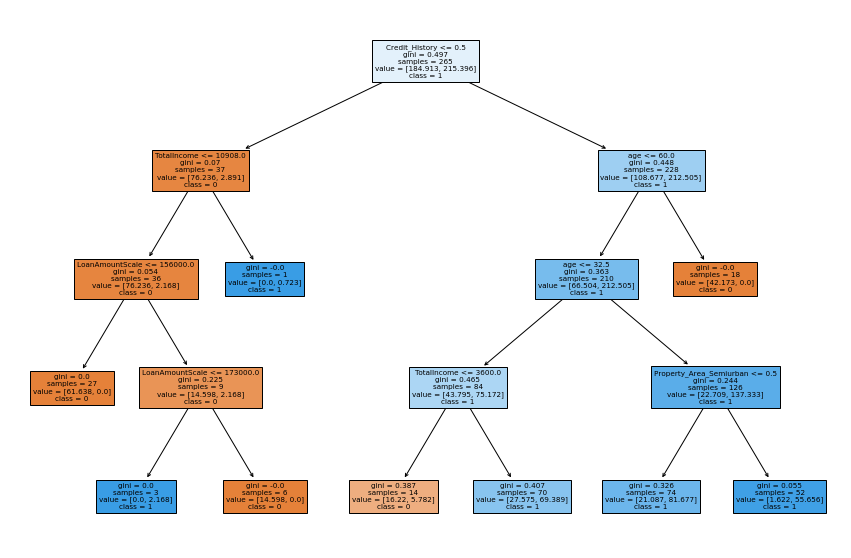

In [11]:
plt.figure(figsize=(15, 10))
plot_tree(best_model[0], filled=True, max_depth=4, feature_names=X_train.columns, class_names=['0', '1'])
plt.show()


#### Feature importance

In [12]:
importances = best_model.feature_importances_
feature_names = X_train.columns

feat_importances = pd.Series(importances, index=feature_names)
top_features = feat_importances.sort_values(ascending=False).head(5).index
print("Top features :", list(top_features))


Top features : ['age', 'Credit_History', 'LoanAmountScale', 'TotalIncome', 'MonthlyPayment']


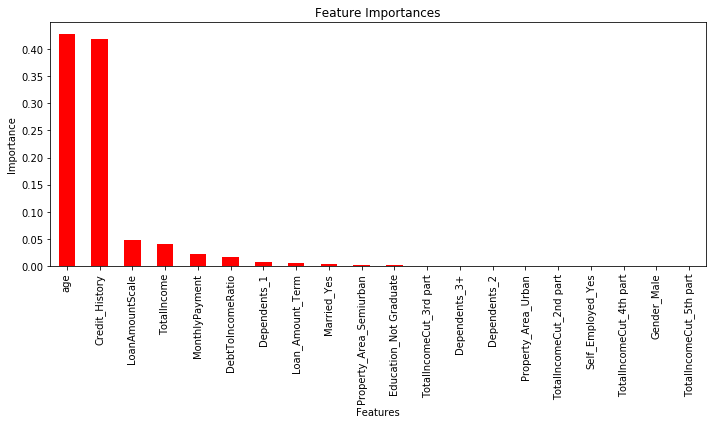

In [13]:
plt.figure(figsize=(10,6))

feat_importances_sorted = feat_importances.sort_values(ascending=False)


feat_importances_sorted.plot(kind='bar', color='red')

plt.title("Feature Importances")
plt.ylabel("Importance")
plt.xlabel("Features")
plt.tight_layout()
plt.show()


In [14]:
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]


In [15]:
reduced_rf = RandomForestClassifier(
    max_depth=best_model.max_depth,
    max_features=best_model.max_features,
    min_samples_leaf=best_model.min_samples_leaf,
    min_samples_split=best_model.min_samples_split,
    n_estimators=best_model.n_estimators,
    class_weight='balanced',
    random_state=123
)

reduced_rf.fit(X_train_reduced, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=4, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=460,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [16]:
y_pred = reduced_rf.predict(X_test_reduced)
y_prob = reduced_rf.predict_proba(X_test_reduced)[:, 1]

print(classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.86      0.67      0.76        55
           1       0.87      0.95      0.91       122

    accuracy                           0.86       177
   macro avg       0.86      0.81      0.83       177
weighted avg       0.86      0.86      0.86       177

AUC Score: 0.8870342771982116
